## Linear Model

Start with packages

In [321]:
from math import prod, sqrt
import matplotlib.pyplot as plot
import numpy as np
import random
from random import gauss, randint, uniform
from sklearn.linear_model import LinearRegression
from statistics import mean

Set constants.

Set *masterSeed* to None to make every run different.  Set it to an integer to repeat to get 
the sam results over and over.

Sigma represents the amount of additive noise in the output.

In [322]:
nGene = 4
nSamp = 100

masterSeed = None
masterSeed = 150

sigma = 0.1

#### Set up the problem

The model assumes that of each gene:
1. Contributors something to the final output
2. That the contributions are additive.
3. That the contributions of each gene are independent of each other.

Writing this model as an algebraic shows that this is equivalent to assuming "the linear model".

In [323]:
if masterSeed is not None:
	seed = masterSeed
else:
	random.seed()
	seed = randint(0, 999)
	
random.seed(seed)
print(f'Seed = {seed}')

Seed = 150


In [324]:
nGene = 4

weightTrue = [uniform(-1,1) for _ in range(nGene)]
print(f'weights = {weightTrue}')

varName = ['x'+str(i) for i in range(nGene)]

weights = [0.6476144839281761, 0.7904183178983359, -0.6242631788932305, -0.3922820566266936]


Make a callable function for this model.

In [325]:
def LinMod(weights, inputs):
	assert(len(weights) == len(inputs))
	result = sum((weight*input for (weight,input) in zip(weights,inputs)))
	return result

Test the *LinMod* function

In [326]:
LinMod(weightTrue, (1,1,1,1)) - sum(weightTrue)

0.0

Assume that each gene (or perhaps SNP) occurs in the population with a fixed proportion, not 
necessarily 1/2.

In [327]:
prev = [uniform(0,1) for _ in range(nGene)]
print(f'Prevalence = {prev}')

Prevalence = [0.4782984565594395, 0.1629042284197154, 0.09176496297891834, 0.744110280968943]


Generate samples

In [328]:
geneSamp = tuple(tuple(uniform(0,1) < p for p in prev) for _ in range(nSamp))
print(f'1st sample = {geneSamp[0]}')
print(f'2nd sample = {geneSamp[1]}')

1st sample = (True, False, False, True)
2nd sample = (False, True, False, True)


In [329]:
geneNum = tuple(tuple(1 if hasGene else 0 for hasGene in samp) for samp in geneSamp)
print(f'1st sample = {geneNum[0]}')
print(f'2nd sample = {geneNum[1]}')

1st sample = (1, 0, 0, 1)
2nd sample = (0, 1, 0, 1)


Generate synthetic measurements

In [330]:
meas = tuple(LinMod(weightTrue, gn) + gauss(0,sigma) for gn in geneNum)
print(f'1st sample = {meas[0]}')
print(f'2nd sample = {meas[1]}')

1st sample = 0.3621369214826788
2nd sample = 0.5339270097930593


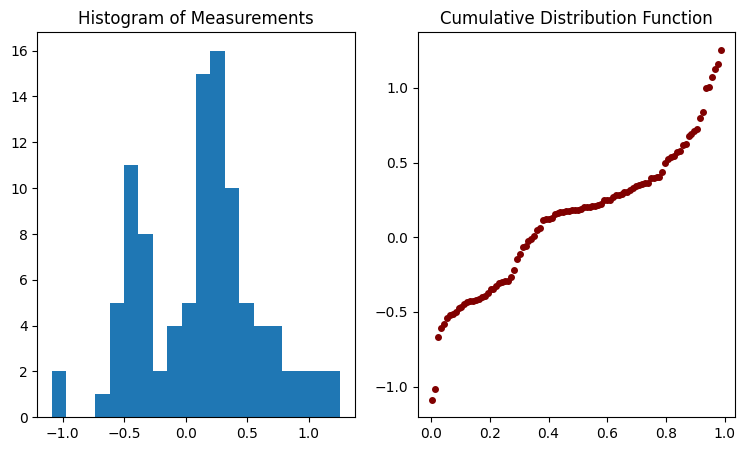

In [331]:
fig, (ax0,ax1) = plot.subplots(1,2, figsize=(9,5))

ax0.hist(meas,bins=20)
ax0.title.set_text('Histogram of Measurements')

x = [(k + 0.5)/(nSamp + 1) for k in range(nSamp)]
ax1.plot(x,sorted(meas), 'o', ms=4, c='maroon')
ax1.title.set_text('Cumulative Distribution Function')

#### Learn Module from (i.e., Fit Model to) the Data

In [332]:
x = np.array(geneNum)
y = np.array(meas)
print(f'x shape = {x.shape}, y shape = {y.shape}')

x shape = (100, 4), y shape = (100,)


In [333]:
reg = LinearRegression()
reg.fit(x,y)
weightFit = reg.coef_
weightFit

In [334]:
nCase = 2 ** nGene
cases = tuple(tuple((num & (1 << bNum)) >> bNum for bNum in range(nGene)) for num in range(nCase))
cases

((0, 0, 0, 0),
 (1, 0, 0, 0),
 (0, 1, 0, 0),
 (1, 1, 0, 0),
 (0, 0, 1, 0),
 (1, 0, 1, 0),
 (0, 1, 1, 0),
 (1, 1, 1, 0),
 (0, 0, 0, 1),
 (1, 0, 0, 1),
 (0, 1, 0, 1),
 (1, 1, 0, 1),
 (0, 0, 1, 1),
 (1, 0, 1, 1),
 (0, 1, 1, 1),
 (1, 1, 1, 1))

In [335]:
prob = tuple(prod((p if g == 1 else (1 - p) for (p,g) in zip(prev,case))) for case in cases)
prob

(0.1014958672619467,
 0.09305189388246808,
 0.019751749447836656,
 0.018108497845234744,
 0.010254795424270295,
 0.00940164522307976,
 0.0019956492350201305,
 0.0018296207112005714,
 0.2951432304175826,
 0.27058871752941327,
 0.05743677349332697,
 0.052658307143272604,
 0.029820262937201764,
 0.02733935890432208,
 0.005803215223375407,
 0.005320415320448333)

Check that the probabilites of the cases add to one

In [336]:
sum(prob)

0.9999999999999999

In [337]:
noNoiseMeas = tuple(LinMod(weightTrue, case) for case in cases)
estMeas = tuple(LinMod(weightFit, case) for case in cases)

In [338]:
error = [(nnm - em, p) for (nnm,em,p) in zip(noNoiseMeas, estMeas, prob)]
error

[(0.0, 0.1014958672619467),
 (-0.0296635562420281, 0.09305189388246808),
 (-0.0446440395633626, 0.019751749447836656),
 (-0.0743075958053907, 0.018108497845234744),
 (0.04804335915905611, 0.010254795424270295),
 (0.01837980291702801, 0.00940164522307976),
 (0.0033993195956935063, 0.0019956492350201305),
 (-0.026264236646334593, 0.0018296207112005714),
 (0.01880650821565022, 0.2951432304175826),
 (-0.01085704802637788, 0.27058871752941327),
 (-0.025837531347712384, 0.05743677349332697),
 (-0.055501087589740594, 0.052658307143272604),
 (0.06684986737470644, 0.029820262937201764),
 (0.03718631113267823, 0.02733935890432208),
 (0.022205827811343726, 0.005803215223375407),
 (-0.007457728430684374, 0.005320415320448333)]

The probability weighted mean RMS error

In [339]:
rmsErr = sqrt(mean(er*er*p for (er,p) in error))
rmsErr

0.006893955384692816

In [340]:
sigma/rmsErr

14.50546085952888

So if the noise is measurement nose (rather than model missmatch), then measuring the gene and 
using them to predict the quantity of interest is dramatically better than making a 
noisy direct measurement of the quantity.

In the real world this phenomena occurs, but in the real world there is also model miss-match.  
If the models are simple model-mismatch will be large.  But in the real world nothing is measured
directly, at the instrumentation level.  The quantity of interest is inferred from physical
measurements using some model (usually involving a calibration process) 

For this example, where there is zero model-mismatch, the expected reduction in rmsError (below 
sigma) is the square root of number of subjects times the number of genes.  Which is the average 
across a large selection of seeds.

In [341]:
sqrt(nGene * nSamp)

20.0